# 生成对抗网络(Generative Adversarial Networks)

生成对抗网络的开山之作：https://arxiv.org/abs/1406.2661

在之前的学习中，我们一直都在讲如何预测，即我们使用深度神经网络完成从数据点到标签的映射，这种学习方式就是所谓的判别式学习，即我们在一张照片是猫还是狗的判别问题中不断学习，分类器和回归器都属于判别式学习.

深度神经网络另一种学习方式我们称为生成式学习，例如，给定一个数据集，在没有任何标签的情况下，我们可能想要学习一个模型来精准地捕获数据的特性。如果我们拥有这样一个模型，我们就可以合成和训练数据所服从的分布极为相像的数据点，我们可以生成和原照片极为相像的照片类型，这种模型我们称之为生成式模型。

2014年，Ian Goodfeelow引入生成对抗网络，一种十分新颖的方法，利用判别式模型的强大能力来获得一个鲁棒的生成式模型。

例如，GAN可以用来生成以假乱真的卧室图片：

<img src="http://gluon.mxnet.io/_images/fake_bedrooms.png" width="700">

GAN的核心是说，我们判断一个数据生成器好坏的标准是如果我们不能区分真实数据和伪造的数据，从统计学的角度是说，我们要回答这样一个问题，数据集$X = \{x_1, \ldots x_n\}$和$X' = \{x_1', \ldots x_n'\}$是否来自同一个分布，换句话说，与其仅仅训练一个模型来说“嘿，这两个数据集看起来不像他们来自同一分布”，GANs使用双样本测试为生成模型提供训练信号。 这使我们能够改进数据生成器，直到它生成类似于真实数据的东西。 至少，它需要欺骗分类器。 并且如果我们的分类器是最先进的深度神经网络的话，那么生成器的威力将更加强大。


<font color="red">正如你所看到的，GAN有两个部分，首先，我们需要一个device（比如深度网络，但它可能是任何东西，比如游戏渲染引擎），它们用来生成可能是真实东西的数据。如果我们正在处理图像，则需要生成图像。如果我们正在处理语音，它需要生成音频序列，等等。我们称之为generator network。 第二个组件是discriminator network， 它试图区分伪造和真实数据。两个网络都在相互竞争，generator network试图通过产生更强大的数据来欺骗discriminator network。 而此时，discrimintor网络需要适应新的假数据。这些信息反过来被用来改善generator network，等等。</font>

GAN的运行流程：

<img src="http://gluon.mxnet.io/_images/simple-gan.png" width="400">


简而言之，我们有两个优化问题同时运行，如果二者已经达到了僵局，优化就会终止。关于如何修改这个基本设置还有很多其他技巧和细节。例如，我们可以在存在辅助信息的情况下尝试解决这个问题，这就导致了cGAN，即conditional Generative Adversarial Networks；我们可以改变我们如何检测真实和虚假数据是否看起来一样，这导致了wGAN，即Wasserstein GAN，kernel-inspired GAN等，又或者我们可以改变我们仔细观察对象的方式，例如，伪造的图像可能在纹理层次看起来更像真实数据但是在较大的层次上看起来并不是，反之亦然。

下面我们用一个例子来说明GAN的基本思想。

即我们通过generator来生成像真实样本那样服从同一个分布的假样本

In [1]:
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import gluon
from mxnet import autograd

%matplotlib inline
import matplotlib as mlt
mlt.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

ctx = mx.cpu()

mx.random.seed(1)

## 生成真实数据

In [2]:
X = nd.random.normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X, A) + b
Y = nd.ones(shape=(1000, 1))

batch_size = 4 
train_data = mx.io.NDArrayIter(X, Y, batch_size=batch_size, shuffle=True)

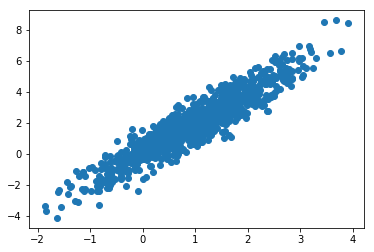

The covariance mxtrix is

[[5.   0.9 ]
 [0.9  0.26]]
<NDArray 2x2 @cpu(0)>


In [3]:
plt.scatter(X[:, 0].asnumpy(), X[:, 1].asnumpy())
plt.show()
print("The covariance mxtrix is")
print(nd.dot(A, A.T))

## 定义网络
* 生成器(generator): 单层线性模型
* 判别器(discriminator): 3层感知机

可以看到与之前所不同的是，我们需要定义两个不同的网络，每个网络都有他们自己的梯度，优化器，损失函数，我们可以对其分别进行优化。

In [4]:
# build generator
generator = gluon.nn.Sequential()
with generator.name_scope():
    generator.add(gluon.nn.Dense(2))

In [5]:
discriminator = gluon.nn.Sequential()
with discriminator.name_scope():
    discriminator.add(gluon.nn.Dense(5, activation='tanh'))
    discriminator.add(gluon.nn.Dense(3, activation='tanh'))
    discriminator.add(gluon.nn.Dense(2))

In [6]:
# loss fuction
softmax_crossentropy = gluon.loss.SoftmaxCrossEntropyLoss()

# initializer
generator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for generator and discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': 0.05})

## 训练

In [7]:
real_label = nd.ones((batch_size,), ctx=ctx) #1
fake_label = nd.zeros((batch_size,), ctx=ctx) #0

metric = mx.metric.Accuracy()

from datetime import datetime
import time
import os

binary training acc at epoch 0: accuracy=0.504000.
time: 1.456573


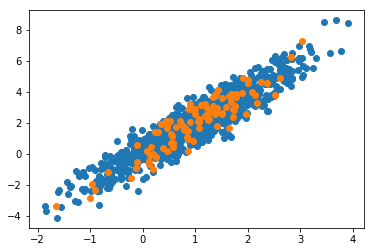

binary training acc at epoch 1: accuracy=0.500500.
time: 1.656428


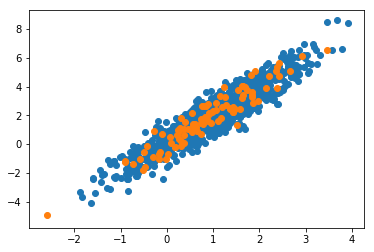

binary training acc at epoch 2: accuracy=0.489000.
time: 1.448607


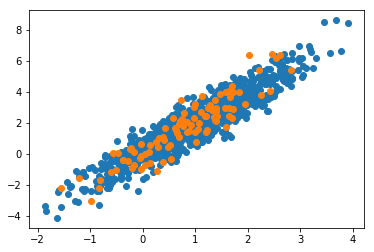

binary training acc at epoch 3: accuracy=0.494000.
time: 1.453539


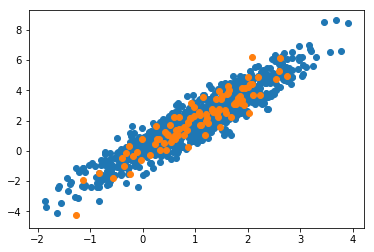

binary training acc at epoch 4: accuracy=0.490000.
time: 1.454691


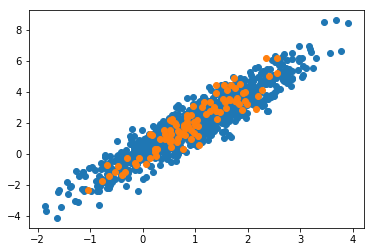

binary training acc at epoch 5: accuracy=0.490500.
time: 1.442440


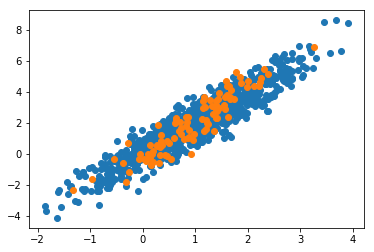

binary training acc at epoch 6: accuracy=0.493500.
time: 1.444779


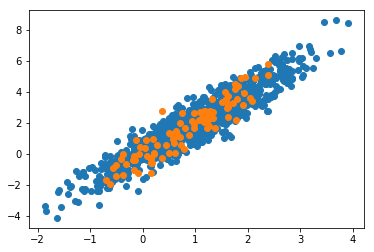

binary training acc at epoch 7: accuracy=0.505000.
time: 1.437309


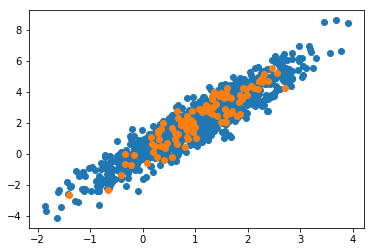

binary training acc at epoch 8: accuracy=0.495000.
time: 1.513932


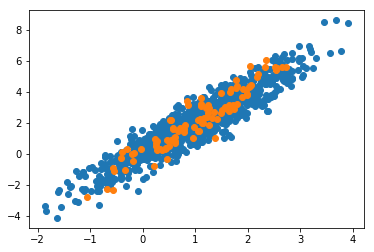

binary training acc at epoch 9: accuracy=0.497500.
time: 1.407467


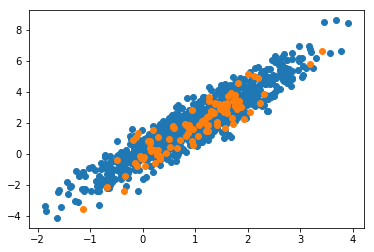

binary training acc at epoch 10: accuracy=0.499500.
time: 1.392850


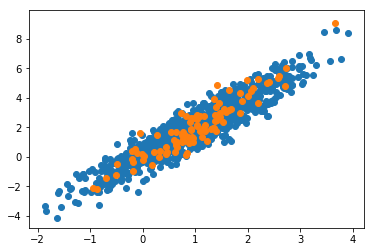

binary training acc at epoch 11: accuracy=0.502000.
time: 1.398700


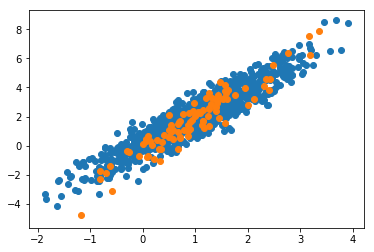

binary training acc at epoch 12: accuracy=0.500000.
time: 1.459885


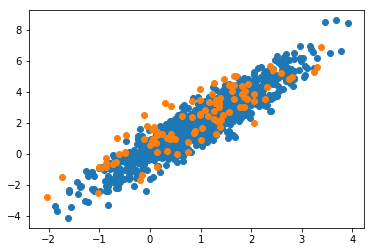

binary training acc at epoch 13: accuracy=0.504000.
time: 1.624428


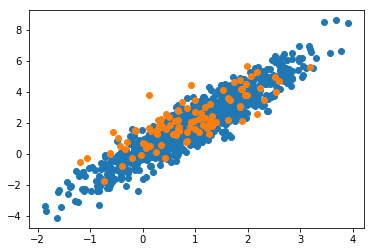

binary training acc at epoch 14: accuracy=0.538500.
time: 1.557140


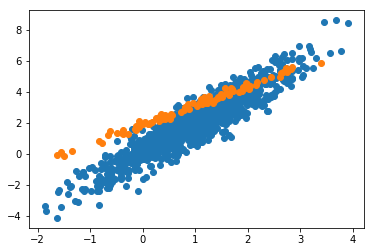

binary training acc at epoch 15: accuracy=0.551000.
time: 1.552815


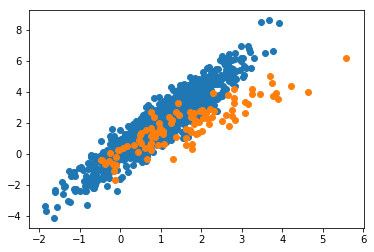

binary training acc at epoch 16: accuracy=0.508000.
time: 1.551570


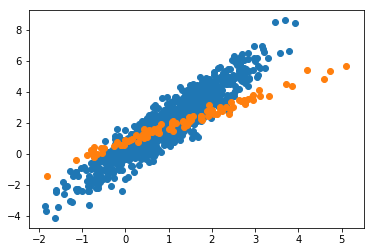

binary training acc at epoch 17: accuracy=0.519000.
time: 1.582063


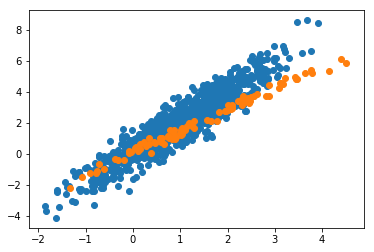

binary training acc at epoch 18: accuracy=0.500500.
time: 1.559329


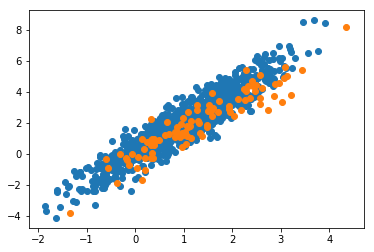

binary training acc at epoch 19: accuracy=0.484500.
time: 1.541386


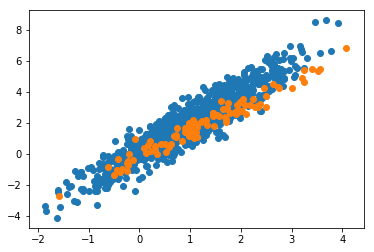

In [11]:
stamp = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
for epoch in range(20):
    tic = time.time()
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random.normal(shape=(batch_size, 2), ctx=ctx)
        
        ###########################
        # (1) Update discriminator: maximzie log(D(x)) + log(1 - D(G(z)))
        ###########################
        with autograd.record():
            real_output = discriminator(data)
            err_discrim_real = softmax_crossentropy(real_output, real_label)
            
            fake = generator(noise)
            fake_output = discriminator(fake.detach())
            err_discrim_fake = softmax_crossentropy(fake_output, fake_label)
            
            err_discrim = err_discrim_real + err_discrim_fake
            err_discrim.backward()
            
        trainerD.step(batch_size)
        metric.update([real_label,], [real_output,])
        metric.update([fake_label,], [fake_output,])
        
        ###########################
        # (2) Update generator: 
        ###########################        
        with autograd.record():
            output = discriminator(fake)
            err_generator = softmax_crossentropy(output, real_label)
            err_generator.backward()
            
        trainerG.step(batch_size)
        
    name, acc = metric.get()
    metric.reset()
    print("binary training acc at epoch %d: %s=%f." % (epoch, name, acc))
    print("time: %fs." % (time.time() - tic))
    noise = nd.random.normal(shape=(100, 2), ctx=ctx)
    
    # generator generate fake data to deceive the discriminator,
    # and discriminator continously learn to distinguish, and this 
    # info propgate to generator again to generate new ddta
    fake = generator(noise)
    plt.scatter(X[:, 0].asnumpy(), X[:, 1].asnumpy())
    plt.scatter(fake[:, 0].asnumpy(), fake[:, 1].asnumpy())
    plt.show()

## 验证结果

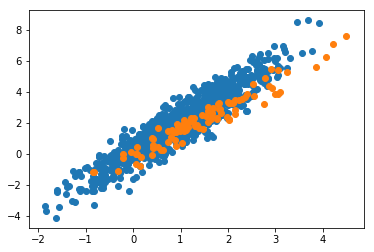

In [15]:
noise = nd.random.normal(shape=(100, 2), ctx=ctx)
fake = generator(noise)

plt.scatter(X[:, 0].asnumpy(), X[:, 1].asnumpy())
plt.scatter(fake[:, 0].asnumpy(), fake[:, 1].asnumpy())
plt.show()